## BERT model:

In [1]:
# For retrieving the clauses and labels.
import os
import json
# For the duplicates
from collections import defaultdict, Counter
# For BERT
import torch
import numpy as np
from datasets import load_dataset, Dataset
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, TrainerCallback
from sklearn.metrics import accuracy_score, classification_report
# For deduplication
import nltk
from nltk.util import ngrams
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
nltk.download('punkt')
# For metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# For plots 
import matplotlib.pyplot as plt

/Users/benjaminward/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/benjaminward/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/benjaminward/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### 1. Extracting the individual clauses and labels

#### a. Data extraction

In [2]:
data_dir = "data"  # Data directory containing company folders
clause_pairs = []

# Step 1: Check if data directory exists
if not os.path.exists(data_dir):
    print(f"❌ ERROR: Data directory '{data_dir}' does not exist.")
    exit()

# Step 2: Initialize a counter for the companies
company_counter = 0

# Step 3: Loop through all company folders inside the data directory
for company in os.listdir(data_dir):
    company_path = os.path.join(data_dir, company)

    # Check if it's a directory (company folder)
    if os.path.isdir(company_path):
        clause_file = os.path.join(company_path, "clauses.json")

        # Step 4: Check if clauses.json exists
        if not os.path.isfile(clause_file):
            print(f"❌ ERROR: 'clauses.json' not found in '{company}' folder")
            continue

        try:
            # Step 5: Check if clauses.json is valid JSON
            with open(clause_file, "r", encoding="utf-8") as f:
                data = json.load(f)

            # Step 6: Check if 'clauses' key exists
            if "clauses" not in data:
                print(f"⚠️ WARNING: No 'clauses' key found in '{company}/clauses.json'")
                continue

            clauses = data["clauses"]
            if not clauses:
                print(f"⚠️ WARNING: 'clauses' list is empty in '{company}/clauses.json'")
                continue

            # Step 7: Extract (title, rating) pairs
            for clause in clauses:
                title = clause.get("title", "").strip() if clause.get("title") else ""
                rating = clause.get("rating", "").strip() if clause.get("rating") else ""

                if title and rating:
                    clause_pairs.append((title, rating))
                else:
                    print(f"⚠️ WARNING: Skipping a clause in '{company}' due to missing title or rating.")
        
        except json.JSONDecodeError:
            print(f"❌ ERROR: Invalid JSON in '{company}/clauses.json'")

        # Step 8: Stop after the first 2 companies
        company_counter += 1
        if company_counter >= 900:
            break  # Exit the loop after processing the first two companies

# Final results
print(f"\n✅ Extracted {len(clause_pairs)} clause-rating pairs from the first two companies.\n")
for pair in clause_pairs[:5]:  # Print first 5 for checking
    print(pair)


⚠️ WARNING: 'clauses' list is empty in 'RESEARCHCHEMAIAL SWITZERLAND/clauses.json'
⚠️ WARNING: 'clauses' list is empty in 'Kink.com/clauses.json'

✅ Extracted 14407 clause-rating pairs from the first two companies.

('Instead of asking directly, this Service will assume your consent merely from your usage.', 'bad')
('This service tracks which web page referred you to it', 'bad')
('The service can sell or otherwise transfer your personal data as part of a bankruptcy proceeding or other type of financial transaction.', 'bad')
('You must provide your legal name, pseudonyms are not allowed', 'bad')
('This service employs third-party cookies, but with opt-out instructions', 'bad')


#### b. Duplicate analysis

In [3]:
clause_pairs = []  # Reset to include folder info

# Step 3: Loop through all company folders inside the data directory
for company in os.listdir(data_dir):
    company_path = os.path.join(data_dir, company)

    if os.path.isdir(company_path):
        clause_file = os.path.join(company_path, "clauses.json")

        if not os.path.isfile(clause_file):
            print(f"❌ ERROR: 'clauses.json' not found in '{company}' folder")
            continue

        try:
            with open(clause_file, "r", encoding="utf-8") as f:
                data = json.load(f)

            if "clauses" not in data:
                print(f"⚠️ WARNING: No 'clauses' key found in '{company}/clauses.json'")
                continue

            clauses = data["clauses"]
            if not clauses:
                print(f"⚠️ WARNING: 'clauses' list is empty in '{company}/clauses.json'")
                continue

            # Store (title, rating, folder)
            for clause in clauses:
                title = clause.get("title", "").strip() if clause.get("title") else ""
                rating = clause.get("rating", "").strip() if clause.get("rating") else ""

                if title and rating:
                    clause_pairs.append((title, rating, company))  # Store the folder name
                else:
                    print(f"⚠️ WARNING: Skipping a clause in '{company}' due to missing title or rating.")

        except json.JSONDecodeError:
            print(f"❌ ERROR: Invalid JSON in '{company}/clauses.json'")


⚠️ WARNING: 'clauses' list is empty in 'RESEARCHCHEMAIAL SWITZERLAND/clauses.json'
⚠️ WARNING: 'clauses' list is empty in 'Kink.com/clauses.json'


In [4]:
# Count occurrences of each (clause, rating) pair
pair_counts = Counter((title, rating) for title, rating, _ in clause_pairs)

# Get the top 5 most duplicated pairs
most_common_pairs = pair_counts.most_common(10)

# Map each (clause, rating) to its folder locations
pair_locations = defaultdict(set)
for title, rating, folder in clause_pairs:
    pair_locations[(title, rating)].add(folder)

# Print the results
print("\n🔍 Top 10 most duplicated clause-rating pairs:")
for (title, rating), count in most_common_pairs:
    folders = list(pair_locations[(title, rating)])  # Convert set to list
    print(f"Clause: {title}\nRating: {rating}\nOccurrences: {count}\nFound in folders: {', '.join(folders)}")
    print("-" * 80)



🔍 Top 10 most duplicated clause-rating pairs:
Clause: There is a date of the last update of the agreements
Rating: neutral
Occurrences: 198
Found in folders: Roadtrip Nation, Mozilla Thunderbird, Privacy.com, Canvas, GeeksforGeeks, Yello, Vivaldi, Medium, Fedora, Opera, TubeBuddy, GlobaliD, Toggl Track, Gather Town, Elk.zone, Zoom Video Communications, ClassDojo, hCaptcha, WikiTree, Encyclopedia Britannica, Credit Karma, Replika, Malwarebytes, Skillshare, YNAB. (You Need a Budget), Open Collective, Microspot, Crain's Chicago Business, Authy (Twilio), Uber, Free, RethinkDNS, SpaceHey, Busuu, Jitsi, FreeTube, Jeuxvideo.com, Prisma Media, Represent, Xiaomi, Vercel, PayPal, NBC News, Guilded, Dark Reader, Lichess, Reddit, Translate, Zoho, Forbes, Audacity, Nextcloud, Nslookup, Notion, LBRY, Wish, Google, Weblate, Metager, Selfie2Anime, eBuddy, SpanishDict, MobyGames, kik-messenger, Gfycat, CNN, The Movie Database (TMDb), Speedtest by Ookla, F-List, Merriam-Webster, Bilibili, Fedora Email,

#### c. Processing code:

In [5]:
data_dir = "data"  # Data directory containing company folders
clause_pairs = []

# Step 1: Check if data directory exists
if not os.path.exists(data_dir):
    print(f"❌ ERROR: Data directory '{data_dir}' does not exist.")
    exit()

# Step 2: Initialize a counter for the companies
company_counter = 0

# Step 3: Loop through all company folders inside the data directory
for company in os.listdir(data_dir):
    company_path = os.path.join(data_dir, company)

    # Check if it's a directory (company folder)
    if os.path.isdir(company_path):
        clause_file = os.path.join(company_path, "clauses.json")

        # Step 4: Check if clauses.json exists
        if not os.path.isfile(clause_file):
            print(f"❌ ERROR: 'clauses.json' not found in '{company}' folder")
            continue

        try:
            # Step 5: Check if clauses.json is valid JSON
            with open(clause_file, "r", encoding="utf-8") as f:
                data = json.load(f)

            # Step 6: Check if 'clauses' key exists
            if "clauses" not in data:
                print(f"⚠️ WARNING: No 'clauses' key found in '{company}/clauses.json'")
                continue

            clauses = data["clauses"]
            if not clauses:
                print(f"⚠️ WARNING: 'clauses' list is empty in '{company}/clauses.json'")
                continue

            # Step 7: Extract (title, rating) pairs
            for clause in clauses:
                title = clause.get("title", "").strip() if clause.get("title") else ""
                rating = clause.get("rating", "").strip() if clause.get("rating") else ""

                if title and rating:
                    clause_pairs.append((title, rating))
                else:
                    print(f"⚠️ WARNING: Skipping a clause in '{company}' due to missing title or rating.")
        
        except json.JSONDecodeError:
            print(f"❌ ERROR: Invalid JSON in '{company}/clauses.json'")

        # Step 8: Stop after the first 2 companies
        company_counter += 1
        if company_counter >= 900:
            break  # Exit the loop after processing the first two companies

# Final results
print(f"\n✅ Extracted {len(clause_pairs)} clause-rating pairs from the first two companies.\n")
for pair in clause_pairs[:5]:  # Print first 5 for checking
    print(pair)


⚠️ WARNING: 'clauses' list is empty in 'RESEARCHCHEMAIAL SWITZERLAND/clauses.json'
⚠️ WARNING: 'clauses' list is empty in 'Kink.com/clauses.json'

✅ Extracted 14407 clause-rating pairs from the first two companies.

('Instead of asking directly, this Service will assume your consent merely from your usage.', 'bad')
('This service tracks which web page referred you to it', 'bad')
('The service can sell or otherwise transfer your personal data as part of a bankruptcy proceeding or other type of financial transaction.', 'bad')
('You must provide your legal name, pseudonyms are not allowed', 'bad')
('This service employs third-party cookies, but with opt-out instructions', 'bad')


In [6]:
# Step 1: Initialize a set to store unique clause-rating pairs, and non-unique clause-rating pais.
unique_clause_pairs = set()
non_unique_clause_pairs = set()
occurrences_of_non_unique_clause_pairs = 0

# Step 2: Filter out duplicates by checking if the pair already exists in the set
filtered_clause_pairs = []

for title, rating in clause_pairs:
    # Use a tuple of (description, rating) as the set key
    pair = (title, rating)
    
    # If the pair is not in the set, add it to the filtered list and the set
    if pair not in unique_clause_pairs:
        filtered_clause_pairs.append(pair)
        unique_clause_pairs.add(pair)
    else:
        non_unique_clause_pairs.add(pair)
        occurrences_of_non_unique_clause_pairs +=1

unique_clause_pairs = list(unique_clause_pairs)
non_unique_clause_pairs = list(non_unique_clause_pairs)

# Step 3: Check how many unique pairs there are
print(f"Before removal of duplicates: {len(clause_pairs)} clause-rating pairs.")
print(f"✅ Removed exact duplicates. {len(filtered_clause_pairs)} unique clause-rating pairs.")
print(f"Number of clauses which appear more than once in our dataset: {len(non_unique_clause_pairs)}.")
print(f"Number of clauses which we removed because there were already present once: {occurrences_of_non_unique_clause_pairs}")


Before removal of duplicates: 14407 clause-rating pairs.
✅ Removed exact duplicates. 1123 unique clause-rating pairs.
Number of clauses which appear more than once in our dataset: 447.
Number of clauses which we removed because there were already present once: 13284


In [7]:
# Example of accessing the descriptions and ratings
for pair in unique_clause_pairs[:5]:  # Print first 5 pairs for checking
    title = pair[0]  # Clause description (x)
    rating = pair[1]       # Clause rating (y)
    print(f"Title: {title}\nRating: {rating}\n")

Title: Emails content may be accessed by people working for the service
Rating: neutral

Title: no spidering or crawling
Rating: neutral

Title: There is a date of the last update of the agreements (December 2018)
Rating: neutral

Title: ToS;DR gives no guarantee regarding quality
Rating: neutral

Title: The service can suspend your account if you violate the terms
Rating: neutral



In [10]:
for pair in unique_clause_pairs:
    rating = pair[1]
    if (rating=="bad"):
        print(pair[0])

Your provided identifiable information is actively checked by the service
Any liability on behalf of the service is only limited to $ 50.00
Many third parties are involved in operating the service
Netflix reserve the right to disclose personal info, no notification.
Your personal information is used for many different purposes
Some personal data may be kept after the end of the data retention period or a request for erasure for business purposes
You are tracked via web beacons, tracking pixels and device fingerprinting
[UK] Your data may be processed and stored anywhere in the world
SmartThings tracks you on other websites
Your data is processed and stored in a country that is less friendly to user privacy protection (USA)
You are tracked via browser fingerprinting and device fingerprinting
Service fines users for Terms of Service violations
This service gathers information about you through third parties
Any liability on behalf of the service is only limited to one month of the fees y

### 2. BERT model

#### a. Filtering: removing pairs with "unknown" as label.

In [54]:
# Step 3.1: Filter out clauses with 'unknown' ratings
filtered_clause_pairs = [(title, rating) for title, rating in unique_clause_pairs if rating != "unknown"]

# Split the filtered data
clauses, ratings = zip(*filtered_clause_pairs)  # Extract clauses and their ratings

# Map ratings to integers
rating_dict = {"very bad": 0, "bad": 1, "neutral": 2, "good": 3}  # Modify if you have different ratings
ratings_int = [rating_dict[r] for r in ratings]

# Step 3.2: Split data into train, dev, and test sets (80% train, 10% dev, 10% test)
X_temp, X_test, y_temp, y_test = train_test_split(clauses, ratings_int, test_size=0.2, random_state=42)

# Print size
print(f"Data set size: {len(filtered_clause_pairs)}")
print(f"Train+dev set size: {len(y_temp)}")
print(f"Test set size: {len(y_test)}")

Data set size: 1074
Train+dev set size: 859
Test set size: 215


#### b. Deduplication based on n-gram similarity

In [55]:
def get_ngrams(text, n=3):
    """Convert text into a set of n-grams."""
    tokens = nltk.word_tokenize(text.lower())  # Tokenize and lowercase
    tokens = [t for t in tokens if t.isalnum() and t not in ENGLISH_STOP_WORDS]  # Remove stopwords and non-alphanumeric
    return set(ngrams(tokens, n))

def jaccard_similarity(set1, set2):
    """Compute Jaccard similarity between two sets."""
    intersection = len(set1 & set2)
    union = len(set1 | set2)
    return intersection / union if union != 0 else 0

def deduplicate_test_set(train_clauses, test_clauses, test_labels, threshold=0.7, n=3):
    """Remove test clauses that are too similar to any train clause based on n-gram Jaccard similarity."""
    train_ngrams = [get_ngrams(clause, n) for clause in train_clauses]
    
    filtered_test_clauses = []
    filtered_test_labels = []
    
    for test_clause, test_label in zip(test_clauses, test_labels):
        test_ngram_set = get_ngrams(test_clause, n)
        
        # Check similarity with each train clause
        max_similarity = max(jaccard_similarity(test_ngram_set, train_set) for train_set in train_ngrams)
        
        if max_similarity < threshold:
            filtered_test_clauses.append(test_clause)
            filtered_test_labels.append(test_label)
    
    return filtered_test_clauses, filtered_test_labels

In [56]:
# Apply deduplication
print(f"Before deduplication: test+dev set size is {len(y_test)}")
X_test, y_test = deduplicate_test_set(X_temp, X_test, y_test, threshold=0.7, n=3)
print(f"After deduplication: test+dev set size is {len(y_test)}")

Before deduplication: test+dev set size is 215
After deduplication: test+dev set size is 158


#### c. Training BERT

In [57]:
X_train, X_dev, y_train, y_dev = train_test_split(X_temp, y_temp, test_size=0.15, random_state=42)
print(f"Train set size: {len(y_train)}")
print(f"Dev set size: {len(y_dev)}")

# Step 3.3: Convert into a format that Hugging Face can use
train_data = Dataset.from_dict({"text": X_train, "label": y_train})
dev_data = Dataset.from_dict({"text": X_dev, "label": y_dev})
test_data = Dataset.from_dict({"text": X_test, "label": y_test})

Train set size: 730
Dev set size: 129


In [58]:
# Step 4.1: Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Step 4.2: Define a function to tokenize the input texts
def tokenize_function(examples):
    return tokenizer(examples.get('text', ""), padding='max_length', truncation=True, max_length=512)

# Step 4.3: Apply the tokenizer to the train, dev, and test datasets
train_data = train_data.map(tokenize_function, batched=True)
dev_data = dev_data.map(tokenize_function, batched=True)
test_data = test_data.map(tokenize_function, batched=True)

# Step 4.4: Set the format for PyTorch
train_data.set_format(type='torch', columns=['input_ids', 'attention_mask', 'token_type_ids', 'label'])
dev_data.set_format(type='torch', columns=['input_ids', 'attention_mask', 'token_type_ids', 'label'])
test_data.set_format(type='torch', columns=['input_ids', 'attention_mask', 'token_type_ids', 'label'])

# Step 4.5: Remove the original text filed
train_data = train_data.map(tokenize_function, batched=True, remove_columns=["text"])
dev_data = dev_data.map(tokenize_function, batched=True, remove_columns=["text"])
test_data = test_data.map(tokenize_function, batched=True, remove_columns=["text"])

# Step 4.6: Make sure we are working with longs
train_data = train_data.map(lambda x: {"label": torch.tensor(x["label"]).long()})
dev_data = dev_data.map(lambda x: {"label": torch.tensor(x["label"]).long()})
test_data = test_data.map(lambda x: {"label": torch.tensor(x["label"]).long()})

Map:   0%|          | 0/730 [00:00<?, ? examples/s]

Map:   0%|          | 0/129 [00:00<?, ? examples/s]

Map:   0%|          | 0/158 [00:00<?, ? examples/s]

Map:   0%|          | 0/730 [00:00<?, ? examples/s]

Map:   0%|          | 0/129 [00:00<?, ? examples/s]

Map:   0%|          | 0/158 [00:00<?, ? examples/s]

Map:   0%|          | 0/730 [00:00<?, ? examples/s]

/var/folders/zl/gjtb3by11p7b_j804bt863qh0000gn/T/ipykernel_16976/3550178219.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_data = train_data.map(lambda x: {"label": torch.tensor(x["label"]).long()})


Map:   0%|          | 0/129 [00:00<?, ? examples/s]

/var/folders/zl/gjtb3by11p7b_j804bt863qh0000gn/T/ipykernel_16976/3550178219.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dev_data = dev_data.map(lambda x: {"label": torch.tensor(x["label"]).long()})


Map:   0%|          | 0/158 [00:00<?, ? examples/s]

/var/folders/zl/gjtb3by11p7b_j804bt863qh0000gn/T/ipykernel_16976/3550178219.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_data = test_data.map(lambda x: {"label": torch.tensor(x["label"]).long()})


In [59]:
# Step 5.1: Take a smaller sample (e.g., 5%) of the training data
train_sample = train_data.shuffle(seed=42).select(range(int(0.1 * len(train_data))))
dev_sample = dev_data.shuffle(seed=42).select(range(int(0.2*len(dev_data))))

In [60]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)  # Convert logits to predicted labels

    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    f1 = f1_score(labels, preds, average='weighted')

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

In [61]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=4)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [62]:
# Step 0: Create a custom callback to store losses
class LossesCallback(TrainerCallback):
    def __init__(self):
        self.train_losses = []
        self.dev_losses = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            if 'loss' in logs:  # Capture training loss
                self.train_losses.append(logs['loss'])
            if 'eval_loss' in logs:  # Capture development loss
                self.dev_losses.append(logs['eval_loss'])

# Step 1: Instantiate the custom callback
losses_callback = LossesCallback()

In [63]:
# Step 2: Modify TrainingArguments to log losses during training
training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy="epoch",  # Evaluate after each epoch
    save_strategy="epoch",  # Save model at each epoch
    save_total_limit=2,  # Keep last 2 checkpoints
    learning_rate=5e-5,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    num_train_epochs=6,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,  # Log every 10 steps
    report_to="tensorboard",  # Optional: To use TensorBoard for more advanced plotting
)

# Step 3: Create Trainer with the custom callback
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_sample,
    eval_dataset=dev_sample,
    compute_metrics=compute_metrics,
    callbacks=[losses_callback]  # Add the callback to store losses
)

In [64]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.141600,1.112098,0.360000,0.129600,0.360000,0.190588
2,0.977600,0.979429,0.560000,0.606364,0.560000,0.546860


TrainOutput(global_step=222, training_loss=0.4861600384502126, metrics={'train_runtime': 364.4867, 'train_samples_per_second': 1.202, 'train_steps_per_second': 0.609, 'total_flos': 115244711682048.0, 'train_loss': 0.4861600384502126, 'epoch': 6.0})

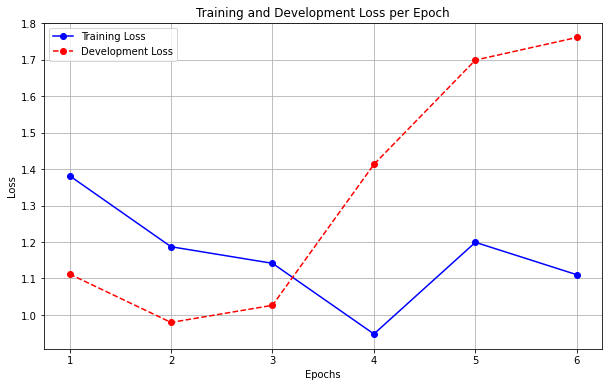

In [65]:
# Step 5: Plot the training and development losses
epochs = list(range(1, len(losses_callback.train_losses) + 1))  # Create an array for epochs (assuming one log per epoch)

# Ensure both training and development losses are the same length
min_len = min(len(losses_callback.train_losses), len(losses_callback.dev_losses))

plt.figure(figsize=(10, 6))
plt.plot(epochs[:min_len], losses_callback.train_losses[:min_len], label="Training Loss", marker='o', linestyle='-', color='b')
plt.plot(epochs[:min_len], losses_callback.dev_losses[:min_len], label="Development Loss", marker='o', linestyle='--', color='r')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Development Loss per Epoch")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Evaluate on the train set
train_results = trainer.evaluate(train_data)
# Print loss and accuracy
print(f"Train Loss: {train_results['eval_loss']:.4f}")
print(f"Train Accuracy: {train_results['eval_accuracy']:.4f}")  # Accuracy from compute_metrics
# Evaluate on the dev set
dev_results = trainer.evaluate(dev_data)
# Print loss and accuracy
print(f"Dev Loss: {dev_results['eval_loss']:.4f}")
print(f"Dev Accuracy: {dev_results['eval_accuracy']:.4f}")  # Accuracy from compute_metrics

In [66]:
# Evaluate on the test set
test_results = trainer.evaluate(test_data)

# Print loss and accuracy
print(f"Test Loss: {test_results['eval_loss']:.4f}")
print(f"Test Accuracy: {test_results['eval_accuracy']:.4f}")  # Accuracy from compute_metrics

Test Loss: 1.7990
Test Accuracy: 0.6076
